[1. 0. 1. ... 7. 6. 9.]


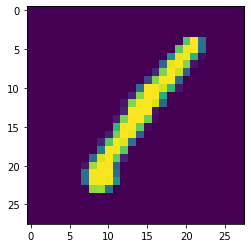

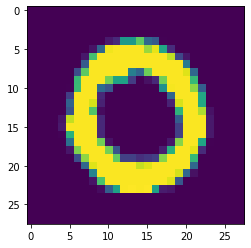

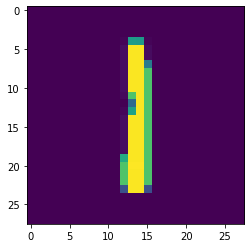

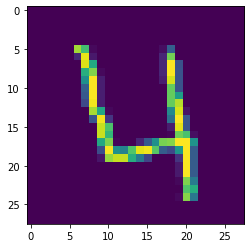

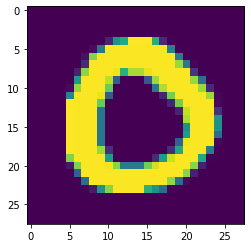

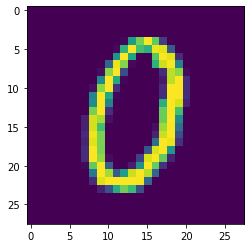

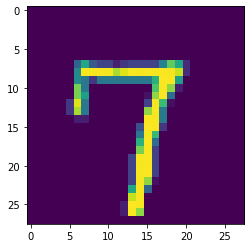

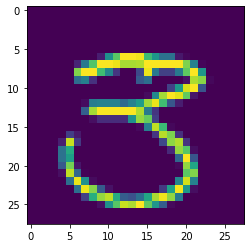

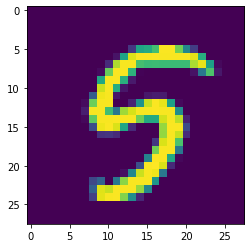

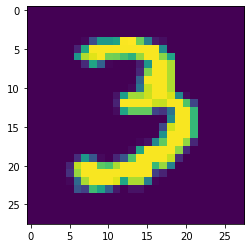

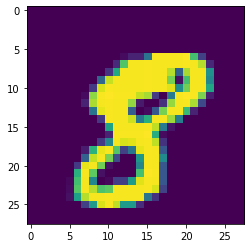

<ipython-input-20-5609480dc386>:74: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration: 500  Loss: 0.345724880695343  Accuracy: 87.25 %
[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
[tensor(38.5357), tensor(62.0476), tensor(74.9762), tensor(78.8333), tensor(80.4881), tensor(81.4048), tensor(84.5833), tensor(84.7024), tensor(85.4881), tensor(87.2500), tensor(87.1548), tensor(87.6071), tensor(88.1786)]


In [20]:
# importing packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split



# Prepare Dataset
# load data
train = pd.read_csv("train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
train_X = (train.drop("label", axis=1)).values/255
train_y = train["label"].values
print(train_y)
features_train, features_test, targets_train, targets_test = train_test_split(train_X,
                                                                             train_y,
                                                                             test_size = 0.2,
                                                                             random_state = 50) 

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)


# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

batch_size = 100

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

for i in range(0,11): 
  first = train_X[i]
  first = np.array(first,dtype='float')
  first_pixel = first.reshape((28,28))
  plt.imshow(first_pixel)
  plt.show()

# Definition of a CNN Model class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)



num_epochs = 2
learning_rate = 0.1
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                 # Forward propagation
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

print(iteration_list)
print(accuracy_list)